# 09 - Moon Phase Correlation Analysis

This notebook analyzes the relationship between earthquake occurrence and lunar phases/cycles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os, sys, warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))
from config import *
from visualization import setup_style
setup_style()

OUTPUT_DIR = os.path.join(FIGURES_PATH, '09_moon')
os.makedirs(OUTPUT_DIR, exist_ok=True)

eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'))
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')

eq_moon = eq_df[eq_df['moon_phase'].notna()].copy()
print(f"Records with moon data: {len(eq_moon):,}")

Records with moon data: 524,952


In [2]:
# Moon phase distribution
print("\nEarthquake Distribution by Moon Phase:")
phase_counts = eq_moon['moon_phase'].value_counts()
print(phase_counts)


Earthquake Distribution by Moon Phase:
moon_phase
Waning       304525
New Moon     120240
Waxing        53972
Full Moon     46215
Name: count, dtype: int64


In [3]:
# Statistics by moon phase
moon_stats = eq_moon.groupby('moon_phase').agg({
    'eventID': 'count',
    'magnitude': ['mean', 'max'],
    'depth': 'mean'
}).round(2)
moon_stats.columns = ['count', 'mag_mean', 'mag_max', 'depth_mean']
moon_stats

,count,mag_mean,mag_max,depth_mean
moon_phase,,,,
Full Moon,46215,1.99,7.4,8.19
New Moon,120240,1.97,6.8,8.17
Waning,304525,1.98,7.7,8.16
Waxing,53972,1.99,7.2,8.19


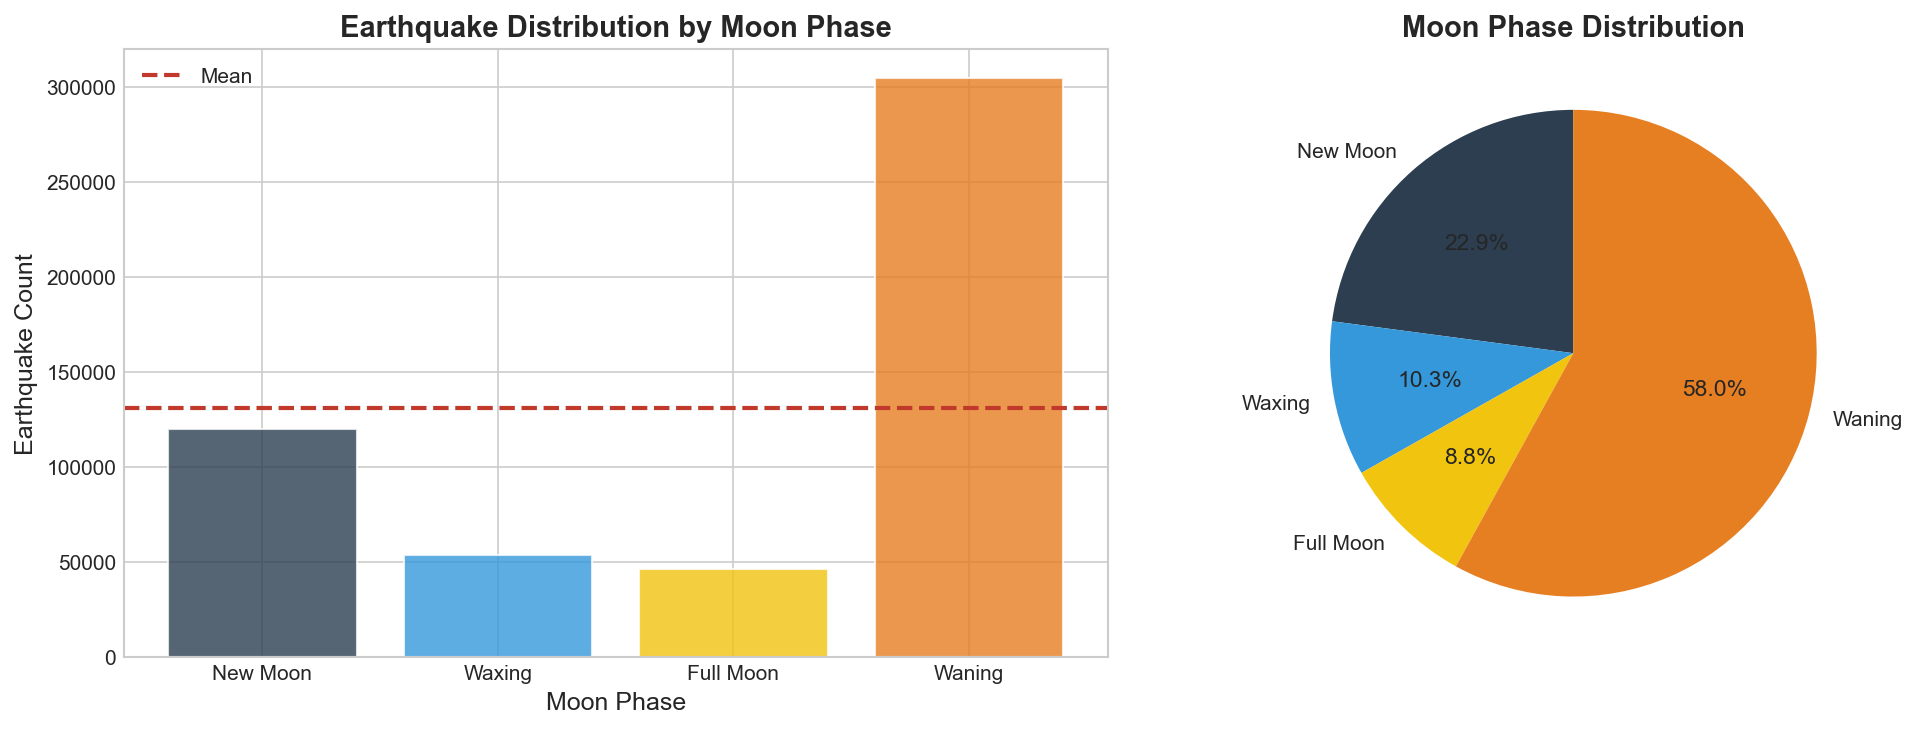

In [4]:
# Bar plot of earthquake counts by moon phase
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

phase_order = ['New Moon', 'Waxing', 'Full Moon', 'Waning']
colors = [MOON_PHASE_COLORS.get(p, 'gray') for p in phase_order]

ax1 = axes[0]
counts = [phase_counts.get(p, 0) for p in phase_order]
ax1.bar(phase_order, counts, color=colors, alpha=0.8, edgecolor='white')
ax1.axhline(np.mean(counts), color=COLORS['danger'], linestyle='--', linewidth=2, label='Mean')
ax1.set_xlabel('Moon Phase')
ax1.set_ylabel('Earthquake Count')
ax1.set_title('Earthquake Distribution by Moon Phase', fontweight='bold')
ax1.legend()

# Pie chart
ax2 = axes[1]
ax2.pie(counts, labels=phase_order, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Moon Phase Distribution', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'moon_phase_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# Chi-square test for uniform distribution
observed = [phase_counts.get(p, 0) for p in phase_order]
expected = [sum(observed) / len(phase_order)] * len(phase_order)

chi2, p_value = stats.chisquare(observed, expected)

print("\nChi-square Test (Uniform Moon Phase Distribution):")
print(f"  Chi² = {chi2:.4f}")
print(f"  p-value = {p_value:.4f}")
print(f"  Result: {'NOT uniform' if p_value < 0.05 else 'Uniform'} (α=0.05)")
print(f"  Interpretation: {'Moon phase DOES affect' if p_value < 0.05 else 'No evidence that moon phase affects'} earthquake frequency")


Chi-square Test (Uniform Moon Phase Distribution):
  Chi² = 330302.8518
  p-value = 0.0000
  Result: NOT uniform (α=0.05)
  Interpretation: Moon phase DOES affect earthquake frequency


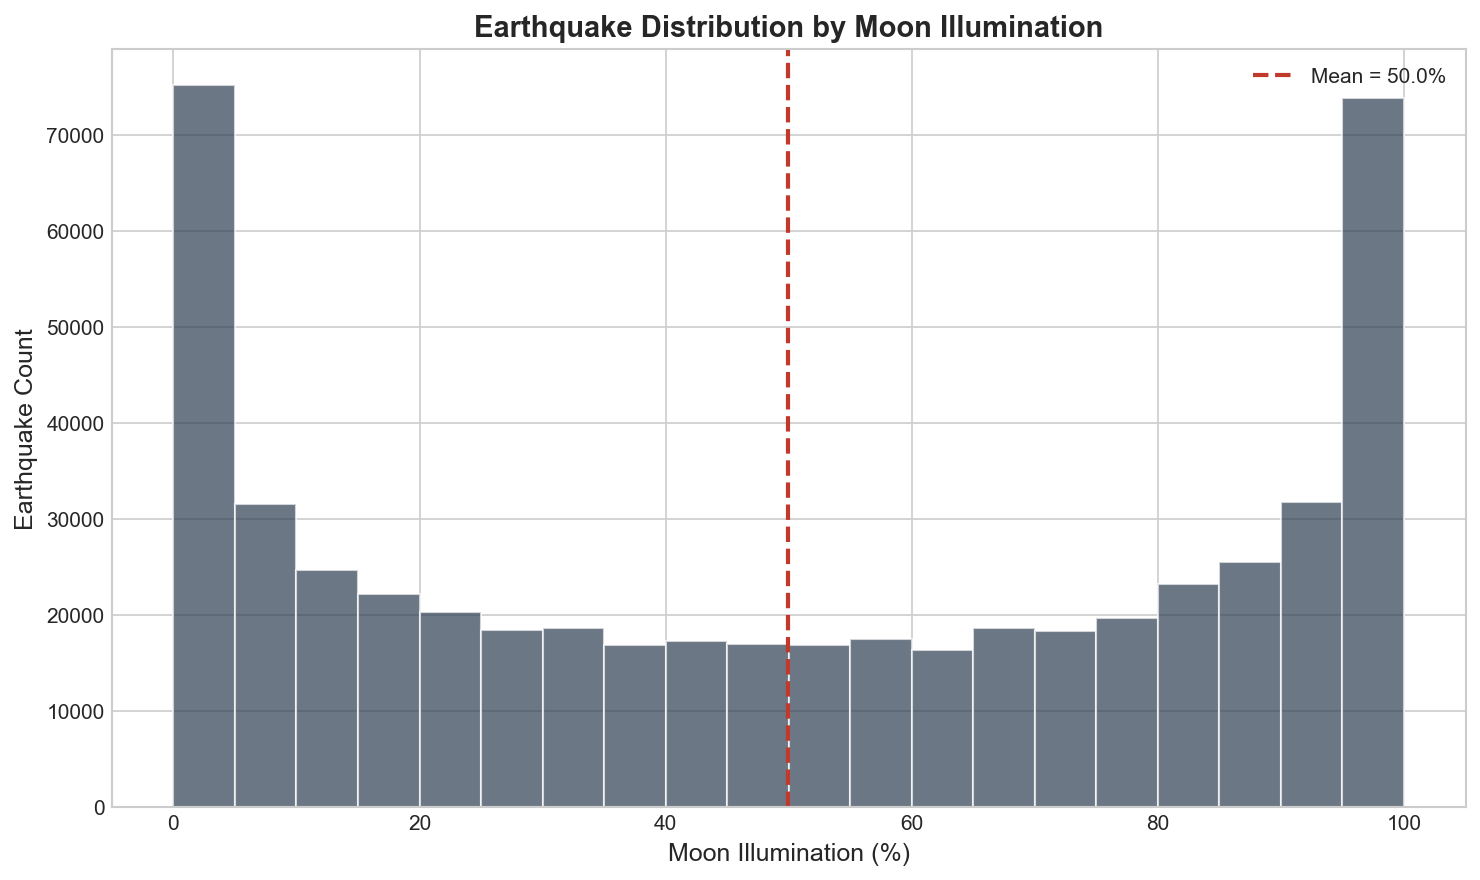

In [6]:
# Illumination analysis
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(eq_moon['illumination'], bins=20, color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax.axvline(eq_moon['illumination'].mean(), color=COLORS['danger'], linestyle='--', 
           linewidth=2, label=f'Mean = {eq_moon["illumination"].mean():.1f}%')
ax.set_xlabel('Moon Illumination (%)')
ax.set_ylabel('Earthquake Count')
ax.set_title('Earthquake Distribution by Moon Illumination', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'illumination_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Correlation between illumination and magnitude
r, p = stats.pearsonr(eq_moon['illumination'].dropna(), eq_moon.loc[eq_moon['illumination'].notna(), 'magnitude'])
print(f"\nCorrelation (Illumination vs Magnitude):")
print(f"  r = {r:.4f}, p-value = {p:.4e}")


Correlation (Illumination vs Magnitude):
  r = 0.0110, p-value = 1.4605e-15


In [8]:
# ANOVA for magnitude by moon phase
groups = [eq_moon[eq_moon['moon_phase'] == p]['magnitude'].values for p in phase_order]
f_stat, p_val = stats.f_oneway(*groups)

print(f"\nANOVA (Magnitude by Moon Phase):")
print(f"  F = {f_stat:.4f}, p-value = {p_val:.4f}")
print(f"  Result: {'Significant' if p_val < 0.05 else 'No significant'} difference")


ANOVA (Magnitude by Moon Phase):
  F = 24.3026, p-value = 0.0000
  Result: Significant difference


In [9]:
# Save results
moon_stats.to_csv(os.path.join(TABLES_PATH, 'moon_phase_analysis.csv'))
print(f"\nResults saved to: {os.path.join(TABLES_PATH, 'moon_phase_analysis.csv')}")


Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/moon_phase_analysis.csv
